# Video Preprocessing

Description

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import motion_detection as md
import mediapipe_holistic as mh
import video_preprocessing as vp

## Load Data

In [7]:
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess'

In [8]:
root = '../../'
video_dir = f'{root}data/raw/combined/videos'

In [9]:
video_metadata_df = pd.read_csv(f'{root}data/raw/combined/target_dataset_video_metadata.csv')
video_metadata_df.head()

,filename,label,data_source,frame_count,fps,duration_sec,width,height
0,banana_ne_1.mp4,banana,ne,51,12.00000,4,240,176
1,banana_sb_2.mp4,banana,sb,71,29.97003,2,1920,1080
2,banana_uf_3.mp4,banana,uf,246,29.97003,8,1920,1080
3,banana_vl_4.mp4,banana,vl,168,29.97003,5,1920,1080
4,banana_vl_5.mp4,banana,vl,378,59.94006,6,1280,720


# Processing One Example Video

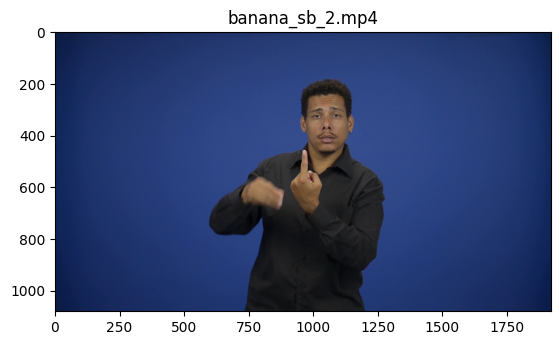

In [24]:
i = 1
row = video_metadata_df.iloc[i]
video_path = f'{video_dir}/{row["filename"]}'
# show frame
frame_index = 30
frame = md.get_frame(video_path, frame_index)
plt.imshow(frame[:,:,::-1])
plt.title(f'{row["filename"]}')
plt.show()


## Make All Signers Right-Handed (ToDo)

In [28]:
pass

## Motion Detection and Video Trimming

### Motion Detection

In [11]:
# parameters for creating the motion data
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds
fps = video_metadata_df.iloc[i]["fps"]

In [12]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(video_path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(video_path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Basic motion detection took 0.42 seconds
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Background subtraction method took 1.76 seconds

Total processing time: 2.18 seconds


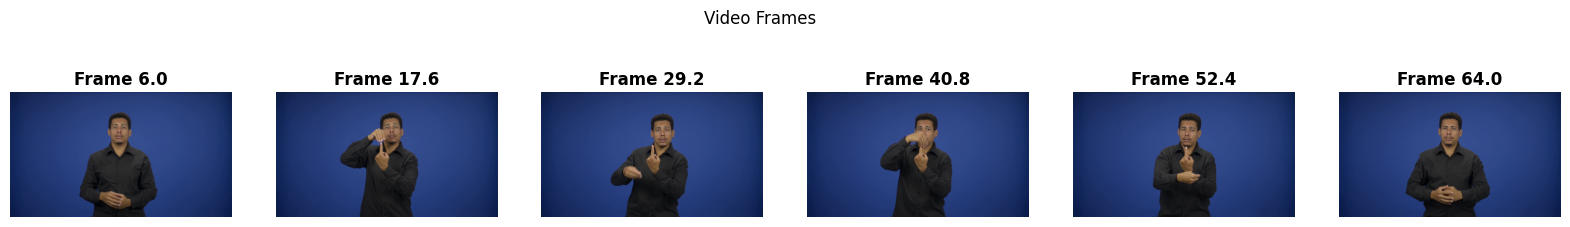

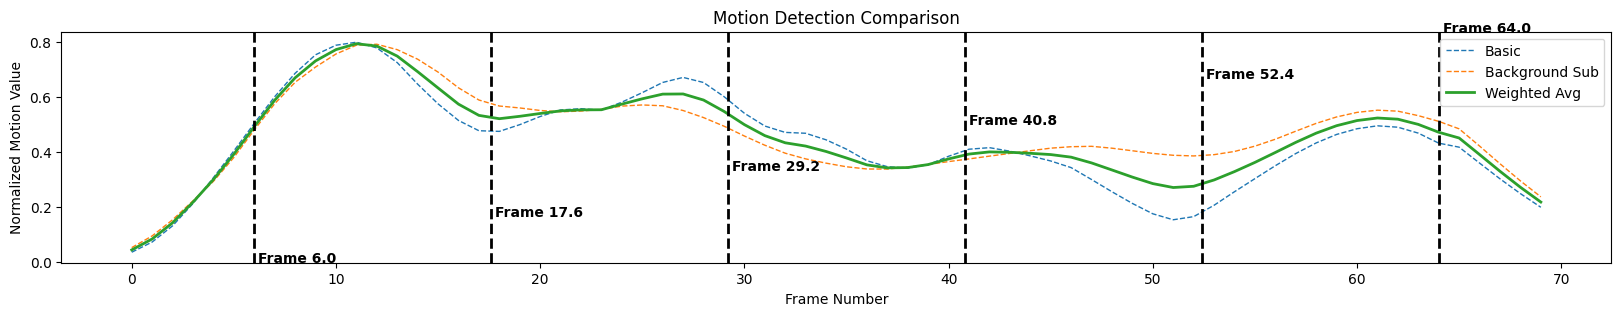

In [13]:
n = 6
frame_samples = np.linspace(n, len(mm_combined)-n, n)
md.show_multiple_frames_one_plot(video_path, frame_samples, [mm_basic, mm_bg_sub, mm_combined])

### Video Trimming

In [14]:
# parameters for trimming the video
start_threshold=0.25
end_threshold=0.25

In [15]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.2,
    end_threshold=0.2
)
start_frame, end_frame

(3, 69)

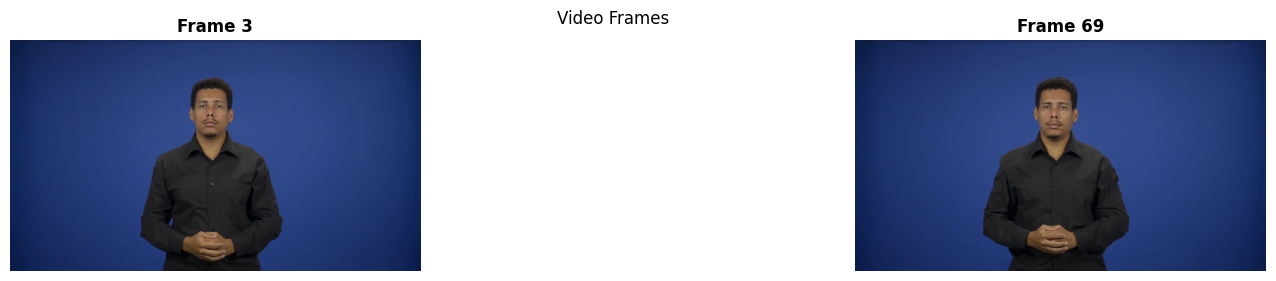

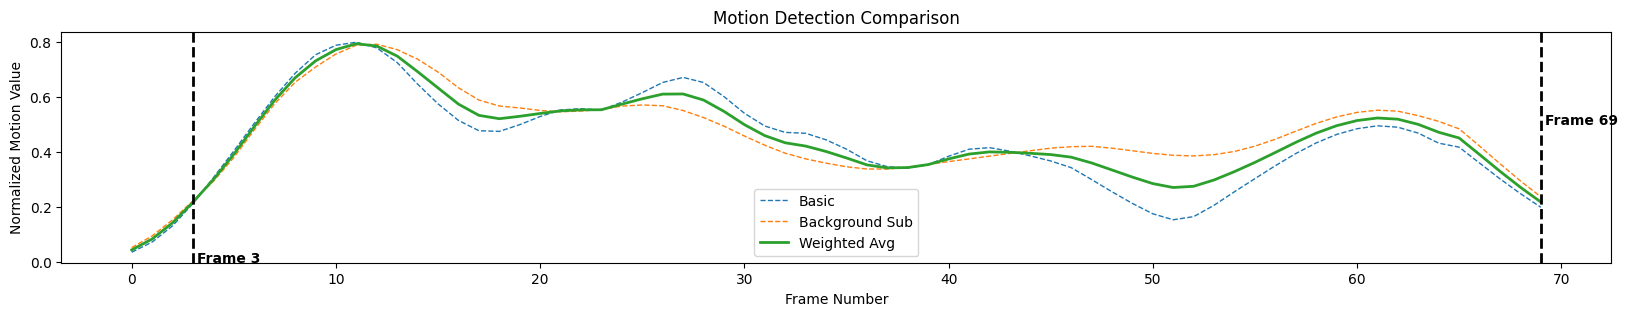

In [16]:
md.show_multiple_frames_one_plot(video_path, [start_frame, end_frame], [mm_basic, mm_bg_sub, mm_combined])

## MediaPipe Pose Detection -> Center & Scale

### Pose Detection

In [28]:
# Initialize detector
mediapipe = mh.MediaPipeHolistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1,  # 0=Lite, 1=Full, 2=Heavy
    refine_face_landmarks=True
)

landmarks = mediapipe.process_video(video_path)

W0000 00:00:1743078118.142359   41643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743078118.185165   41643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743078118.187596   41649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743078118.188194   41650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743078118.190323   41643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743078118.234788   41649 inference_feedback_manager.cc:114] Feedback manager 

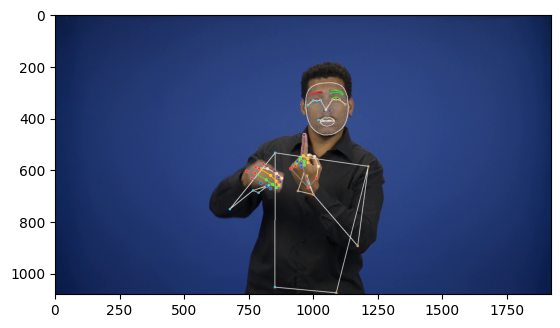

In [29]:
annotated_frame = mediapipe.draw_landmarks_on_frame(frame, landmarks[frame_index])
plt.imshow(annotated_frame[:,:,::-1])

### Horizontal Alignment, to have Signers in the center of the video

In [30]:
horizontal_offsets = mediapipe.get_video_horizontal_offsets(landmarks)
horizontal_offset = 0.5 - (horizontal_offsets['shoulders']['median'] + horizontal_offsets['face']['median'])/2
horizontal_offset

-0.01764950156211853

In [31]:
horizontal_aligned_landmarks = mediapipe.shift_landmarks_series_horizontally(landmarks, horizontal_offset)

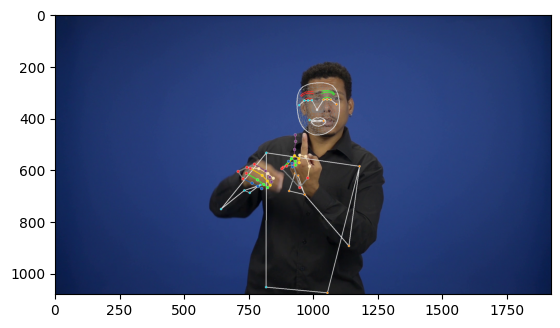

In [32]:
annotated_frame = mediapipe.draw_landmarks_on_frame(frame, horizontal_aligned_landmarks[frame_index])
plt.imshow(annotated_frame[:,:,::-1])

### Standardise the Scale of the Signer (todo)

In [ ]:
pass

### Vertical Alignment, to have Signers in the same position (todo)



In [ ]:
pass 

### Save the landmarks

In [37]:
landmarks_interim = horizontal_aligned_landmarks
landmarks_interim = landmarks_interim[start_frame:end_frame]
print(len(landmarks_interim))

66


In [38]:
landmarks_interim_save_dir = f'{root}/data/interim/landmarks_before_padding'
os.makedirs(landmarks_interim_save_dir, exist_ok=True)
np.save(f'{landmarks_interim_save_dir}/{row.filename.split(".")[0]}_landmarks.npy', landmarks_interim)

### Process and Save a Video

In [77]:
int(round(row.width*horizontal_offset, 0))

-34

In [62]:
horizontal_pixel_offset = int(round(row.width*horizontal_offset, 0))
horizontal_pixel_offset

-34

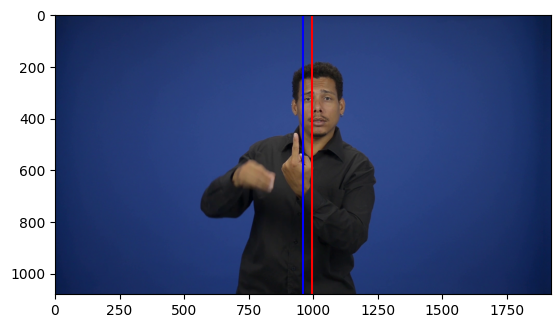

In [75]:
# shift the frame horizontally by the horizontal_pixel_offset
shifted = np.roll(frame, horizontal_pixel_offset, axis=1)
plt.imshow(shifted[:,:,::-1])
plt.axvline(row.width//2, color='blue')
plt.axvline(row.width//2 - row.width*horizontal_offset, color='red')
plt.show()


In [79]:
# load video frame by frame, apply horizontal alignment, save as video
video_interim_save_dir = f'{root}/data/interim/aligned_trimmed_videos'
os.makedirs(video_interim_save_dir, exist_ok=True)
output_path = f'{video_interim_save_dir}/{row.filename}'

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f"Error opening video file: {video_path}")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError(f"Error creating output video file: {output_path}")

try:
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error reading video.")
            break
            
        # trim the video
        if i < start_frame:
            i += 1
            continue
        if i > end_frame:
            break

        # horizontal alignment
        horizontal_pixel_offset = int(round(row.width*horizontal_offset, 0))
        horizontally_aligned_frame = np.roll(frame, -horizontal_pixel_offset, axis=1)
        # scale
        pass
        # vertical alignment
        pass

        # save the frame
        out.write(horizontally_aligned_frame)
        i += 1  # Increment frame counter

finally:
    # Clean up resources
    cap.release()
    out.release()

## Resize Dimensions (for video only)

In [ ]:
pass

## Padding

In [ ]:
pass

# Processing the Full Dataset

In [ ]:
for i, row in video_metadata_df.iterrows():

    if i % (len(video_metadata_df) // 10) == 0:
        print(f'{i/len(video_metadata_df)*100}% done')
    video_path = f'{video_dir}/{row["filename"]}'
    fps = row['fps']

    mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(video_path)), fps, window_duration=window_duration, verbose=False)
    mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(video_path)), fps, window_duration=window_duration, verbose=False)
    mm_combined = md.weighted_average_motion([mm_basic, mm_bg_sub,], weights = [0.5, 0.5],)

    # save the motion data as numpy arrays
    np.save(f'{root}data/raw/combined/motion_detection/{row["filename"].split(".")[0]}_basic.npy', mm_basic)
    np.save(f'{root}data/raw/combined/motion_detection/{row["filename"].split(".")[0]}_bg_sub.npy', mm_bg_sub)
    np.save(f'{root}data/raw/combined/motion_detection/{row["filename"].split(".")[0]}_combined.npy', mm_combined)

# save txt file with the parameters used for motion detection
with open(f'{root}data/raw/combined/motion_detection/motion_detection_parameters.txt', 'w') as f:
    f.write(f'window_duration: {window_duration}\n')
    f.write(f'weights: {weights}\n')

print('100.0% done')